# Lecture Notes: Linear softmax classifier, and stochastic gradient descent (from scratch)

Here we will implement SGD for a linear classifier using a softmax function and negative log likelihood loss. These terms will be more clear as we finish this lecture. The idea is that you will learn these concepts by crunching numbers in Torch. Torch contains a powerful set of libraries for training complex machine learning and deep learning models but for this lecture we will not be using any of those libraries so you can easily translate this code to any other language of your choice.

## 1. First let's load some training data. 
We will be using the CIFAR-10 dataset. CIFAR-10 is a dataset consisting of 50k training images belonging to 10 categories. A validation set is also provided which contains 10k images. We have a version of this dataset here that has all the images resized to 32x32. This is a relatively small dataset so it is very convenient to experiment with. You will probably read several papers reporting results on this dataset during this class but most state-of-the-art methods usually try experiments in much larger datasets with millions of images.

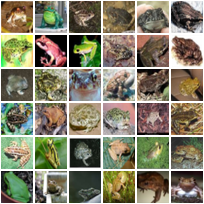

{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}
{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [49]:
require 'image'
-- The default tensor type in Torch is DoubleTensor, but we generally only need Float precision.
torch.setdefaulttensortype('torch.FloatTensor')

-- Load data.
trainset = torch.load('cifar10-train.t7') -- training images.
valset = torch.load('cifar10-val.t7')  -- validation set used to evaluate the model and tune parameters.
trainset.label = trainset.label + 1
valset.label = valset.label + 1
classes = {'airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'}

-- Let's show all images of frogs.
class2ids = {}  -- Build a mapping between object names and class ids.
-- Remember that tables in lua are similar to (key,value) collections e.g. hashmaps.
for k,v in pairs(classes) do class2ids[v] = k end

-- Retrieve the frog class number.
object_class_id = class2ids['frog'] -- try changing this to visualize some images from other categories.
-- Put all images of frogs into a table.
objects = {}
local object_indices = trainset.label:eq(object_class_id):nonzero():squeeze()
for i = 1, 36 do  -- Let's show the first 36 frogs.
    table.insert(objects, trainset.data[object_indices[i]])
end

-- Plot the images of frogs using itorch.image
itorch.image(objects)
print(trainset) -- View what is inside the training set.
print(valset)  -- View what is inside the validation set.

## 2. Preprocessing and normalizing the data.
The images in this dataset are already pre-processed a bit, they are all 3x32x32, this means they have three channels (RGB), and they all have a width and height of 32 pixels. It is also generally a good idea in machine learning to center the inputs around zero. Each RGB value in our ByteTensor inputs goes from 0 to 255. We want the values to go from -1 to 1, if possible. This sometimes makes learning a function on these inputs easier. 

In [51]:
-- Make the data a FloatTensor.
trainset.normdata = trainset.data:clone():float()
valset.normdata = valset.data:clone():float()
cifarMean = {trainset.normdata[{{}, {1}, {}, {}}]:mean(),
             trainset.normdata[{{}, {2}, {}, {}}]:mean(),
             trainset.normdata[{{}, {3}, {}, {}}]:mean()}

cifarStd = {trainset.normdata[{{}, {1}, {}, {}}]:std(),
            trainset.normdata[{{}, {2}, {}, {}}]:std(),
            trainset.normdata[{{}, {3}, {}, {}}]:std()}

-- Print the mean and std value for each channel.
print(cifarMean)
print(cifarStd)

-- Now normalize the training and validation data.
for i  = 1, 3 do
    -- Subtracting the mean on each channel makes the values roughly between -128 and 128.
    trainset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    valset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    -- Dividing the std on each channel makes the values roughly between -1 and 1.
    trainset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
    valset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
end

{
  1 : 125.30691804687
  2 : 122.95039414062
  3 : 113.86538318359
}
{
  1 : 62.993219892912
  2 : 62.088708246722
  3 : 66.704900292063
}


## 3. Computing the linear sofmax classifier "forward" pass.
The classifier will take as input vectors of size 3x32x32 = 3072, which is the size of the images. The classifier will output vector predictions of size 10, where each entry corresponds to a category. The function representing the linear classifier is:  

$$\hat{y} = softmax(Wx+b)$$

where the $softmax$ function is applied to each element in the vector $a = Wx + b$. The weight matrix $W$ is of size 10x3072, and $b$ is a bias vector of size 10, so the output vector $a$ is of size 10 to match the number of categories that we want to predict. Both $W$ and $b$ need to be learned using the training data. The softmax function is defined for each entry $a_i$ in the vector $a$ as:

$$\hat{y}_i = softmax(a_i) = \frac{exp(a_i)}{\sum_{k=1}^{10}{exp(a_k)}}$$

The softmax function forces the entries in the vector $\hat{y}$ to sum to 1. We will discuss in the next section and during class in more detail why this transformation is necessary.



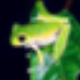

sum(y_hat) = 1.000000	
y_hat[airplane] = 0.000022	
y_hat[automobile] = 0.000000	
y_hat[bird] = 0.135708	
y_hat[cat] = 0.000000	
y_hat[deer] = 0.001169	
y_hat[dog] = 0.000000	
y_hat[frog] = 0.017031	
y_hat[horse] = 0.000000	
y_hat[ship] = 0.017661	
y_hat[truck] = 0.828407	

This image was predicted as truck with confidence 0.828407	


In [52]:
inputSize = 32 * 32 * 3   -- Image size inputs
outputSize = 10  -- Number of categories

-- Pick a frog image from the training data as a 3072 dimensional vector.
image_id = 105 -- Feel free to use another image.

-- We will be using the following variables for later experiments.
input_image = trainset.normdata[image_id] -- this is a 3x32x32 tensor.
input_image_vector = input_image:view(input_image:nElement()) -- expand tensor as 1-D vector.
input_image_label = trainset.label[image_id]

-- Enlarge and show the image.
itorch.image(image.scale(input_image, 80, 80))  

-- Create the parameters for the softmax classifier and initialize them with random weights.
-- normal(0, 0.1) means the weights are sampled from a gaussian distribution with mean 0 and std = 0.1
softmax = {}
softmax.weight = torch.FloatTensor(outputSize, inputSize):normal(0, 0.1)
softmax.bias = torch.FloatTensor(outputSize):normal(0, 0.1)

-- Function that computes the output of a linear softmax function.
function softmax_forward(softmax, input)
    local a = softmax.weight * input + softmax.bias  -- a = Wx + b
    local constant = a:max() -- This is a constant added for numerical stability, e.g. to avoid exp(X) with huge X.
    softmax.output = torch.exp(a - constant):div(torch.exp(a - constant):sum())  -- softmax(a)
    return softmax.output
end

-- Compute the sofmax for our input frog image.
local y_hat = softmax_forward(softmax, input_image_vector)
print(('sum(y_hat) = %.6f'):format(y_hat:sum())) -- The softmax function makes the entries sum to 1.

-- Show the predictions for this image.
for i = 1, 10 do print(string.format('y_hat[%s] = %.6f', classes[i], y_hat[i])) end
-- Now let's print our prediction by taking the maximum score.
-- Note: This will most likely be a wrong prediction since we are using random weights for our model.
local predicted_score, predicted_label = y_hat:max(1)
print(('\nThis image was predicted as %s with confidence %.6f'):
       format(classes[predicted_label[1]], predicted_score[1]))

## 4. Computing the loss function (also known as criterion in Torch)
Loss functions measure the "distance" between a prediction $\hat{y}$ and a true label $y$. In the case of softmax, you can think of your true label $frog$ as a vector with all zeros except in the frog entry where it is one, e.g. $y = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]$. The loss function $\ell(y,\hat{y})$ between the prediction and true label is given then simply by the following equation: 
$$\ell(y, \hat{y})= -\sum_iy_ilog(\hat{y}_i)$$

Since the true label vector $y$ only has one non-zero entry, we know this sum really has only one term that is non-zero so you will usually see this loss function simply stated as:

$$\ell(class, \hat{y}) = -log(\hat{y}_{label})$$

The intuition behind this loss function is that we want the prediction score corresponding to the true label to be as high as possible (close to one), and by doing this we will also push the other scores to go close to zero because the softmax function forces these scores to sum to one. Since we want to pose the problem as a minimization problem, we use $-log(y_{label})$. (There are probabilistic and information theory interpretations of this loss but we will not analyze them for the purpose of this class)

In [53]:
-- Function for computing the loss function for our image above.
function criterion_forward(y_hat_param, class_id)
    return -torch.log(y_hat_param[class_id])
end

-- We had already computed y_hat but just for clarity let's compute it here again.
y_hat = softmax_forward(softmax, input_image_vector)

-- Compute loss value and show.
loss = criterion_forward(y_hat, input_image_label)
print(('Loss: %.6f'):format(loss))

Loss: 4.072728	


## 5. Computing numerical gradients for the parameters $W$ and $b$
The rest of this tutorial will be about modifying the parameters $W$ and $b$ so that the loss for all the images in the training set is as small as possible. Randomly modifying the values of these parameters until finding a set of values for which the loss becomes smaller might work reasonably well when few parameters need to be estimated but our weight matrix $W$ alone has 3072x10 = 30720 parameters, and some models that we will study later in the class have billions of parameters.

We will instead use Stochastic Gradient Descent (SGD), which is an optimization technique that consists on computing the loss for a training sample or a small group of training samples and modifying the parameters $W$ and $b$ by shifting them a small amount in the direction of their gradients, we will go over this in more detail later. We will first focus on how to compute those gradients, particularly $\frac{\partial \ell}{\partial w_{ij}}$ and $\frac{\partial \ell}{\partial b_i}$. 

A simple yet effective first approach is to compute the gradients with a numerical approximation using the definition of derivatives. For a given single input pair $(x, y)$ the output of the loss function $\ell$ just depends on the parameters $W$ and $b$. Taken this into account, for each entry $w_{ij}$ in the weight matrix $W$ we are interested in the following:

$$\frac{\partial \ell(W,b)}{\partial w_{ij}} = \frac{\ell(W + \mathcal{E}_{ij},b) - \ell(W - \mathcal{E}_{ij}, b)}{2\epsilon}, $$

where $\mathcal{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeroes everywhere else. Intuitively this gradient tells us how would the value of the loss changes if we shake a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Next we write code to compute gradients for our frog image using this approach:

In [54]:
-- This function takes as input the softmax model parameters W, and b, the training pair (input, label).
function computeNumericalGradients(softmax, input, label)
    -- Define epsilon as some small value. The smaller the value the better approximation but we
    -- also run into numerical precision issues as it gets smaller, so we can not make it too small.
    local epsilon = 0.0001
    local gradients = {}
    -- Allocate space to store the gradients for each parameter by creating tensors 
    -- with the same size as the parameters.
    gradients.gradWeight = torch.FloatTensor():resizeAs(softmax.weight)
    gradients.gradBias = torch.FloatTensor():resizeAs(softmax.bias)

    -- Now let us compute gradients for each weight.
    softmax_copy = {}
    softmax_copy.weight = softmax.weight:clone() -- remember that without clone those would be the same matrix.
    softmax_copy.bias = softmax.bias:clone()
    for i = 1, softmax.weight:size(1) do
        for j = 1, softmax.weight:size(2) do
            -- Modify the weight(i,j) by epsilon.
            softmax_copy.weight[{i,j}] = softmax_copy.weight[{i,j}] + epsilon
            local y_hat1 = softmax_forward(softmax_copy, input)
            local loss1 = criterion_forward(y_hat1, label)
            
            softmax_copy.weight[{i,j}] = softmax_copy.weight[{i,j}] - 2 * epsilon
            local y_hat2 = softmax_forward(softmax_copy, input)
            local loss2 = criterion_forward(y_hat2, label)
            
            -- Compute the gradient.
            gradients.gradWeight[{i,j}] = (loss1 - loss2) / (2 * epsilon)
            
            -- Restore the weight(i,j) to its original value.
            softmax_copy.weight[{i,j}] = softmax.weight[{i,j}]
        end
    end

    -- Now let's compute gradients for each bias.
    for i = 1, softmax.bias:size(1) do
        -- Modify the bias(i) by epsilon.
        softmax_copy.bias[i] = softmax_copy.bias[i] + epsilon
        local y_hat1 = softmax_forward(softmax_copy, input)
        local loss1 = criterion_forward(y_hat1, label)
        
        softmax_copy.bias[i] = softmax_copy.bias[i] - 2 * epsilon
        local y_hat2 = softmax_forward(softmax_copy, input)
        local loss2 = criterion_forward(y_hat2, label)
        gradients.gradBias[i] = (loss1 - loss2) / (2 * epsilon)
        
        -- Restore the bias(i) to its original value.
        softmax_copy.bias[i] = softmax.bias[i]
    end
    return gradients
end

-- Compute the numerical gradient for the frog image.
gradients = computeNumericalGradients(softmax, input_image_vector, input_image_label)
print(softmax)
print(gradients)

{
  weight : FloatTensor - size: 10x3072
  output : FloatTensor - size: 10
  bias : FloatTensor - size: 10
}
{
  gradBias : FloatTensor - size: 10
  gradWeight : FloatTensor - size: 10x3072
}


If you run the code above, you will probably notice that it is somewhat slow. This is the reason why numerical gradients are not used in practice. In the next section we will go over how to compute the gradients numerically by finding the derivatives of the loss function with respect to each of the parameters. 

## 6. Computing Analytic Gradients ("backward" pass)
Unfortunately the above for loop takes very long to go over only 5 samples. This is because we need to compute the softmax_forward function for every element of $W$ and $b$ in the computeNumericalGradient function!. This makes solving the optimization using SGD extremely expensive because to have a good estimate of $W$ and $b$ we need to go over all the training images many times. Each full pass over all the training images is called an epoch, and training parameters typically requires at least a few dozen epochs. Actually for our specific loss function we could compute the numerical gradient a bit faster by realizing that changing a single weight $w_{ij}$ does not require recomputing everything every time but still we will see here that computing analytic gradients is much more efficient in general.

Again, in practice gradients are computed analytically instead of numerically. This means computing the derivatives $\partial \ell/\partial w_{ij}$ and $\partial \ell/\partial b_{i}$ by first deriving their analytic equation. Typically we do not compute the derivatives with respect to the parameters directly but the derivatives with respect to inputs or outputs, and use those to compute the derivatives with respect to the parameters using the chain rule. First let's write here again our loss function $\ell$ for a single input pair $(x, label)$:

\begin{equation}
\ell(W, b) = -\text{log}(\hat{y}_{label}(W, b)) = -\text{log}\Big(\frac{\text{exp}(a_{label}(W, b))}{\sum_{k=1}^{10}{\text{exp}(a_k(W,b))}}\Big)
\end{equation}

For simplicity we will drop the parameters $W$ and $b$ from the notation but it is important to remember what variables depend on them.

\begin{equation}
\ell = -\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big) =  \text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - a_{label}
\end{equation}

We will compute the derivatives with respect to parameters $w_{ij}$ and $b_i$ using the chain rule as:

\begin{equation}
\frac{\partial \ell}{\partial w_{ij}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial w_{ij}}
\quad\text{and}\quad
\frac{\partial \ell}{\partial b_{i}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial b_{i}}
\end{equation}

These derivatives correspond to the following expressions (you can trust this for now, but an appendix with careful derivations is included at the end, or even better you can try deriving it yourself on paper):

\begin{equation}
\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] = \hat{y}_{i} - y_i  \tag{See Appendix 1, or derive it yourself}
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial w_{ij}} = \frac{\partial}{\partial w_{ij}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 3072}x_{3072} + b_i) = x_j
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial b_{i}} = \frac{\partial}{\partial b_{i}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 3072}x_{3072} + b_i) = 1 
\end{equation}

Next we will compute the gradients with respect to parameters using the formulas above for our frog image and compare them with the ones obtained using our numerical gradients:

In [55]:
-- This function computes gradients using the analytical expressions derived above.
function criterion_softmax_backward(softmax, input_vector, object_class_id, y_hat)
    -- Allocate memory for the gradients.
    softmax.gradWeight = torch.FloatTensor():resizeAs(softmax.weight)
    softmax.gradBias = torch.FloatTensor():resizeAs(softmax.bias)
    
    -- Prepare the true label indicator vector y.
    local y = torch.FloatTensor():resizeAs(y_hat):zero()
    y[object_class_id] = 1
    
    -- Compute the gradient dl_da
    softmax.gradActivations = y_hat - y
    
    -- Compute the gradients dl_dwij in a single operation so analyze this line carefully.
    -- This is a multiplication between a 10x1 column-vector containing dl_dai and a 
    -- 1x3075 row-vector containing da_dwij, which results in a matrix 10x3072 containing dl_dw
    softmax.gradWeight = softmax.gradActivations:view(outputSize, 1) * input_vector:view(1, inputSize)

    -- Compute the gradients dl_dbi
    softmax.gradBias = softmax.gradActivations
    
    return {gradBias = softmax.gradBias, gradWeight = softmax.gradWeight}
end

-- We already computed this but for clarity let's do it again.
y_hat = softmax_forward(softmax, input_image_vector)
loss = criterion_forward(y_hat, input_image_label)

-- Compute analytical gradients using our backward pass function.
local gradients = criterion_softmax_backward(softmax, input_image_vector, input_image_label, y_hat)

-- Compute numerical gradients.
local numericalGradients = computeNumericalGradients(softmax, input_image_vector, input_image_label)

-- Check that the gradients computed using our formulas are roughly 
-- the same we obtain using the numerical approximations.
local b1 = gradients.gradBias; b1 = b1:view(b1:nElement())
local b2 = numericalGradients.gradBias; b2 = b2:view(b2:nElement())
-- Correct way to compute a relative normalized distance between the values of the gradients.
print(torch.norm(b1 - b2) / torch.norm(b1 + b2)) -- This should print something close to zero.

local g1 = gradients.gradWeight; g1 = g1:view(g1:nElement())
local g2 = numericalGradients.gradWeight; g2 = g2:view(g2:nElement())
-- Correct way to compute a relative normalized distance between the values of the gradients.
print(torch.norm(g1 - g2) / torch.norm(g1 + g2)) -- This should print something close to zero.

0.0015471893789138	
0.0012192187277153	


## 7. Stochastic Gradient Descent (SGD)
Now that we compute gradients efficiently we will implement the stochastic gradient descent loop that moves the weights according to the gradients. In each iteration we sample an (input, label) pair and compute the gradients of the parameters, then we update the parameters according to the following rules:

$$w_{ij} = w_{ij} - \lambda\frac{\partial \ell}{\partial w_{ij}}$$

$$b_i = b_i - \lambda\frac{\partial \ell}{\partial b_i}$$

where $\lambda$ is the learning rate. This value is set empirically and is usually modified during training. We will provide additional practical advice on choosing the learning rate as well as other tricks during class and in office hours but there is no single general advice for this. We will also later study other slightly better ways to udpate the parameters than just using the above subtraction.

We implement next a basic stochastic gradient descent loop with 3 epochs. This means we will roughly go over all training examples 3 times. You can also see how the loss decreases while the accuracy increases. It is usually a good idea to keep track of these two when you train any model. Another question is: When do we stop? This is where the validation data comes into play, we compute the accuracy on the validation data and we stop when the accuracy on the validation data does not improve anymore. Run the cell below and be patient because this one will take a minute or two.

In [57]:
-- This is a typical but basic example of a loop performing SGD.
local learningRate = 0.001
print('Learning started... please be patient.')
for epoch = 1, 3 do  -- This is the number of times we will go over all training instances.
    local correct = 0
    local sum_loss = 0
    for i = 1, trainset.normdata:size(1) do -- this will go over each training instance.
        -- Sample an (image, label) pair from the training data randomly.
        local rand_id = torch.random(1, trainset.normdata:size(1))
        local input_vector = trainset.normdata[rand_id]:view(trainset.normdata[rand_id]:nElement())
        local true_label = trainset.label[rand_id]

        -- Make a forward pass.
        local y_hat = softmax_forward(softmax, input_vector)
        local loss = criterion_forward(y_hat, true_label)
        sum_loss = sum_loss + loss -- accumulate the loss in this variable.

        -- Evaluate prediction.
        local predicted_score, predicted_label = y_hat:max(1)
        if (predicted_label[1] == true_label) then correct = correct + 1 end

        -- Compute the gradients.
        local gradients = criterion_softmax_backward(softmax, input_vector, true_label, y_hat)

        -- Vanilla SGD update. W = W - learningRate * gradW
        -- We will study later other parameter update functions.
        softmax.weight = softmax.weight - torch.mul(gradients.gradWeight, learningRate)
        softmax.bias = softmax.bias - torch.mul(gradients.gradBias, learningRate)
        if i % 5000 == 0 then  -- Print this every five thousand iterations.
            print(('train epoch=%d, iteration=%d, image = %d, avg-loss=%.6f, avg-accuracy = %.2f')
                   :format(epoch, i, rand_id, sum_loss / i, correct / i))
        end
    end
    
    local validation_accuracy = 0
    -- Compute accuracy on validation set.
    for i = 1, valset.normdata:size(1) do
        local input_vector = valset.normdata[i]:view(valset.normdata[i]:nElement())
        local true_label = valset.label[i]
        -- We only need forward pass.
        local y_hat = softmax_forward(softmax, input_vector)
        -- Evaluate prediction.
        local predicted_score, predicted_label = y_hat:max(1)
        if (predicted_label[1] == true_label) then 
            validation_accuracy = validation_accuracy + 1
        end
    end
    validation_accuracy = validation_accuracy / valset.normdata:size(1)
    print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
end

Learning started... please be patient.	


train epoch=1, iteration=5000, image = 29249, avg-loss=3.980304, avg-accuracy = 0.24	


train epoch=1, iteration=10000, image = 27074, avg-loss=3.605798, avg-accuracy = 0.26	


train epoch=1, iteration=15000, image = 33286, avg-loss=3.414528, avg-accuracy = 0.27	


train epoch=1, iteration=20000, image = 15885, avg-loss=3.281485, avg-accuracy = 0.27	


train epoch=1, iteration=25000, image = 42729, avg-loss=3.202573, avg-accuracy = 0.28	


train epoch=1, iteration=30000, image = 39249, avg-loss=3.135148, avg-accuracy = 0.28	


train epoch=1, iteration=35000, image = 34571, avg-loss=3.071731, avg-accuracy = 0.29	


train epoch=1, iteration=40000, image = 2938, avg-loss=3.020574, avg-accuracy = 0.29	
train epoch=1, iteration=45000, image = 9064, avg-loss=2.982816, avg-accuracy = 0.29	
train epoch=1, iteration=50000, image = 14612, avg-loss=2.954871, avg-accuracy = 0.30	



validation accuracy at epoch = 1 is 0.3023	


train epoch=2, iteration=5000, image = 25234, avg-loss=2.648101, avg-accuracy = 0.33	


train epoch=2, iteration=10000, image = 13248, avg-loss=2.600378, avg-accuracy = 0.33	
train epoch=2, iteration=15000, image = 5188, avg-loss=2.605946, avg-accuracy = 0.33	


train epoch=2, iteration=20000, image = 3453, avg-loss=2.602721, avg-accuracy = 0.33	
train epoch=2, iteration=25000, image = 33400, avg-loss=2.588716, avg-accuracy = 0.33	
train epoch=2, iteration=30000, image = 10590, avg-loss=2.587330, avg-accuracy = 0.33	
train epoch=2, iteration=35000, image = 41773, avg-loss=2.584122, avg-accuracy = 0.33	
train epoch=2, iteration=40000, image = 8068, avg-loss=2.581350, avg-accuracy = 0.33	


train epoch=2, iteration=45000, image = 26540, avg-loss=2.582157, avg-accuracy = 0.33	
train epoch=2, iteration=50000, image = 9047, avg-loss=2.580927, avg-accuracy = 0.33	

validation accuracy at epoch = 2 is 0.3034	
train epoch=3, iteration=5000, image = 41689, avg-loss=2.595702, avg-accuracy = 0.31	
train epoch=3, iteration=10000, image = 39135, avg-loss=2.569470, avg-accuracy = 0.32	
train epoch=3, iteration=15000, image = 46090, avg-loss=2.561044, avg-accuracy = 0.33	


train epoch=3, iteration=20000, image = 2236, avg-loss=2.532735, avg-accuracy = 0.33	
train epoch=3, iteration=25000, image = 44040, avg-loss=2.535652, avg-accuracy = 0.33	
train epoch=3, iteration=30000, image = 361, avg-loss=2.528593, avg-accuracy = 0.33	
train epoch=3, iteration=35000, image = 20295, avg-loss=2.527354, avg-accuracy = 0.33	


train epoch=3, iteration=40000, image = 4485, avg-loss=2.528810, avg-accuracy = 0.33	


train epoch=3, iteration=45000, image = 27970, avg-loss=2.526853, avg-accuracy = 0.33	
train epoch=3, iteration=50000, image = 25305, avg-loss=2.520866, avg-accuracy = 0.33	

validation accuracy at epoch = 3 is 0.2893	


### Observations:
If you run the code from the previous section, you will now have a model that can make predictions that are much better than random chance (chance is 10% since we have 10 categories) but that is still far from perfect (100% accuracy). You can see how far humanity has reached on this task and dataset <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130">here</a>. Over the course of this class you will learn how to train more robust models that can achieve much higher accuracy but a lot of the principles learned in this lecture will apply to more complex models as well.
Just for fun let's run an image through our trained model by copy-pasting some code we wrote earlier.

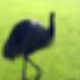

y_hat[airplane] = 0.000521	
y_hat[automobile] = 0.001074	
y_hat[bird] = 0.599535	
y_hat[cat] = 0.004412	
y_hat[deer] = 0.218437	
y_hat[dog] = 0.020010	


y_hat[frog] = 0.004898	
y_hat[horse] = 0.141773	
y_hat[ship] = 0.001437	
y_hat[truck] = 0.007903	

This image of bird was predicted as bird with confidence 0.599535	


In [59]:
-- Pick a frog image from the internet.
local image_id = 124
local input_image = valset.normdata[image_id] -- this is a 3x32x32 tensor.
local input_image_vector = input_image:view(input_image:nElement()) -- expand tensor as 1-D vector.
local input_image_label = valset.label[image_id]

-- Enlarge and show the image.
itorch.image(image.scale(input_image, 80, 80))

-- Compute the sofmax for our input frog image.
local y_hat = softmax_forward(softmax, input_image_vector)

-- Show the predictions for this image.
for i = 1, 10 do print(string.format('y_hat[%s] = %.6f', classes[i], y_hat[i])) end
-- Now let's print our prediction by taking the maximum score.
-- Note: This will most likely be a wrong prediction since we are using random weights for our model.
local predicted_score, predicted_label = y_hat:max(1)
print(('\nThis image of %s was predicted as %s with confidence %.6f'):
       format(classes[input_image_label], classes[predicted_label[1]], predicted_score[1]))

## 8. Mini-batch SGD
Here we will modify our code so that we can run multiple images at a time at training and test time, we will see how this requires only few chagnes. We will also modify our functions slightly to make our code more modular. This means we will not compute the gradient with respect to a single sample during training but with respect to a few samples. This is actually the common choice for training more sophisticated models instead of using pure SGD with a single sample.

In [1]:
-- Pick a random sample of images in a single tensor.
local sample_ids = torch.LongTensor{122, 341, 452, 356}
local input_batch = trainset.normdata:index(1, sample_ids)
local input_batch_vectors = input_batch:view(sample_ids:nElement(), input_batch:nElement() / sample_ids:nElement())
local input_batch_labels = trainset.label:index(1, sample_ids)

-- create a linear layer that encapsulates forward, backward computations.
linear_layer = {weight = softmax.weight, bias = softmax.bias}
function linear_layer:forward(input)
    self.output = self.weight * input:t() + self.bias:repeatTensor(1, input:size(1))  -- a = Wx + b
    self.output = self.output:t()
    return self.output
end

function linear_layer:backward(input, gradOutput)
    self.gradWeight = self.gradWeight + gradOuptut * input  -- dl_dwij
    self.gradBias = self.gradBias = gradOutput              -- dl_dbi
end

-- create a log_softmax layer that encapsulates forward, backward computations.
log_softmax_layer = {}
function log_softmax_layer:forward(input)
    self.output = torch.FloatTensor():resizeAs(input)
    local constant = input:max() -- This is a constant added for numerical stability, e.g. to avoid exp(X) with huge X.
    for i = 1, input:size(1) do
        self.output[i] = torch.log(torch.exp(input[i] - constant):div(torch.exp(input[i] - constant):sum()))
    end
    return self.output
end

function log_softmax_layer:backward(input, gradOutput)
    self.gradInput = 
end

-- The loss now is modified to return the sum of losses for each image.
-- This returns the negative of the label corresponding to ground truth.
-- It assumes that the log probabilities have been given as inputs.
function criterion_forward(input, label)
    local loss = 0
    for i = 1, input:size(1) do loss = loss - input[i][label[i]] end
    return loss
end

-- derivatives for gradients df(x) = d(-x) = -1 
function criterion_backward(input, label)
    local gradients = torch.FloatTensor():resizeAs(input):zero()
    for i = 1, input:size(1) do gradients[i][label[i]] = -1 end
    return gradients
end

local linear_outputs = linear_layer:forward(input_batch_vectors)
local log_y_hat = log_softmax_layer:forward(linear_outputs)
local loss = criterion_forward(log_y_hat, input_batch_labels)
print(loss)
local gradients = criterion_backward(log_y_hat, input_batch_labels)
print(gradients)

require 'nn'
criterion = nn.ClassNLLCriterion()
print(criterion:backward(log_y_hat, input_batch_labels))





[string "-- Pick a random sample of images in a single..."]:17: unexpected symbol near '=': 

## Exercise (20pts)
1. What is the accuracy that you obtained by running the code in Section 7 after three epochs? (3pts)
+ Derive the analytic gradient for the softmax function in isolation (similar derivation as in Appendix 1) (3pts):
<br/><br/>\begin{equation}
\frac{\partial}{\partial a_{i}}\Big[\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big]
\end{equation}<br/>
+ In the previous lecture you learned how to compute the color histogram of an image. Try training the linear softmax function using input color histograms instead of the flattened input images used in this lecture. Modify the code to accomplish this and report here your accuracy for epoch=1, epoch=2, and epoch=3 (6pts).

### Appendix 1: Finding the derivative of the loss with respect to activations $\frac{\partial \ell}{\partial a_i}$
This is the task:
$$\frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] =
\frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})- a_{label}\Big]$$

How do we compute the derivatives of the loss function $\ell$ with respect to the variables $a_i$? There are two cases to consider 1) Derivative with respect to $a_{label}$ and derivative with respect to activations $a_i$ where $i\neq class$. 

Let's start considering the first case when $i = label$:

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)} - a_{label})\Big]$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{label}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}} - 1$$

$$\frac{\partial \ell}{\partial a_{label}}= \hat{y}_{label} - 1 $$

Now let's compute the second case when $i \neq label$:

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - a_{label}\Big]$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})$$

$$\frac{\partial \ell}{\partial a_{i}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{i}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big)$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\text{exp}(a_{i})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}$$

$$\frac{\partial \ell}{\partial a_{i}} =\hat{y}_{i}$$

We can put both derivatives together using an indicator function which takes the value of 1 only when the condition inside the bracket is true:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - \mathbb{1}[j = label]$$

Also by remembering that we had earlier defined $y$ as the ground truth vector containing all zeros except at $y_{label}$, where it contains a 1, we can also simply write:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - y_i$$


<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@cs.virginia.edu